In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

%matplotlib inline

import os
from scipy.stats import itemfreq

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pickle

In [2]:
DATA_ROOT = 'Data'
DB_NAME = 'amiunique-1month-aug17.sqlite3.db'

PATH_TO_DB = os.path.join(DATA_ROOT, DB_NAME)

In [3]:
con = sqlite3.connect(PATH_TO_DB)
df = pd.read_sql_query('select * from fpData', con)

In [4]:
# multicolumn label encoder (borrowed from Stockoverflow) to encode categorical values, added .astype(str)

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        '''
        Note that .fit returned self: this is standard behavior for .fit methods in scikit-learn.
        '''
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

X = MultiColumnLabelEncoder(columns = None).fit_transform(df.astype(str))

## Isolation Forest, train and test parts

Three fundamental approaches to detect anomalies are: isolation, density, and distance. Here we look at isolation. The dataset is split into the train and test parts to test the predictions of iForest and evaluate its performance on new data.
Also, according to https://github.com/scikit-learn/scikit-learn/issues/3112, label encoding doesn't really belong in a Pipeline therefore it is removed and Pipeline for now has only one step.

In [5]:
IFT = IsolationForest(n_estimators=100, max_samples=512, max_features=35, contamination=.15)
pipeline = Pipeline([('IFT', IFT)])

In [6]:
X_train, X_test = train_test_split(X, test_size = 0.12, random_state = 100)

In [7]:
model = pipeline.fit(X_train)
predicted = pipeline.predict(X_test)

In [8]:
# disabling a warning about chained assignments
pd.options.mode.chained_assignment = None

In [9]:
X_test['ift'] = predicted

In [10]:
# anomaly scores, decision function splits them at 0
anomaly_score = pipeline.decision_function(X_test)

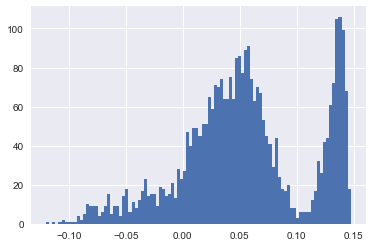

In [11]:
X_test['ift_anom_score'] = anomaly_score
X_test.ift_anom_score.hist(bins=100)
plt.show()

In [12]:
# find a substring 'bot' in the userAgentHttp column (assuming that only good bots openly identify themselves as bots)
X["GoodBot"] = df['userAgentHttp'].str.contains("bot", case = False).astype(int) 
# calculate a frequency column for api keys per each hour in the dataset
X['api/hour'] = df.groupby(['addressHttp','time'])['addressHttp'].transform('count')
# create a new column for frequent ids if the same user has accessed the site >10 times per hour (mark as 1, otherwise 0)
X['frequent/hour'] = np.where(df.groupby(['addressHttp','time'])['addressHttp'].transform('count')>80, 1, 0)

In [13]:
X['frequent/hour'].value_counts()

0    23891
1     2219
Name: frequent/hour, dtype: int64

In [14]:
X_test["GoodBot"] = X["GoodBot"]
X_test['frequent/hour'] = X['frequent/hour']

In [15]:
my = pd.crosstab(X_test['ift'], X_test['GoodBot'], margins=True)
my

GoodBot,0,1,All
ift,,,
-1,417,20,437
1,2690,7,2697
All,3107,27,3134


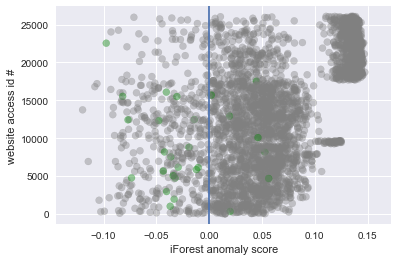

In [16]:
arr1 = X_test['ift_anom_score']
arr2 = X_test.index
labl = X_test['GoodBot']
color= ['gray' if l == 0 else 'green' for l in labl]
plt.scatter(arr1, arr2, color=color, alpha=0.4)
plt.axvline(x=0)
plt.xlabel('iForest anomaly score')
plt.ylabel('website access id #')
plt.show()

In [17]:
# Pickle the pipeline model with iForest (train/test)
fn = pickle.dumps(model)
picpipe_iFst = pickle.loads(fn)
# picpipe_iFst.predict(X_test)

## Isolation Forest, the whole dataset

In [18]:
# dropping newly created columns, returning to the original dataset
drop_list = ['GoodBot', 'api/hour','frequent/hour']
X.drop(drop_list, axis = 1, inplace = True)

In [19]:
iftt = IFT.fit(X)
ift_y = IFT.predict(X)

In [23]:
anomaly_score = pipeline.decision_function(X)

In [24]:
X['ift_y'] = ift_y
X['anomaly_score'] = anomaly_score
X["GoodBot"] = df['userAgentHttp'].str.contains("bot", case = False).astype(int) 
X['api/hour'] = df.groupby(['addressHttp','time'])['addressHttp'].transform('count')
X['frequent/hour'] = np.where(df.groupby(['addressHttp','time'])['addressHttp'].transform('count')>80, 1, 0)

In [25]:
my = pd.crosstab(X['ift_y'], X['GoodBot'], margins=True)
my

GoodBot,0,1,All
ift_y,,,
-1,3765,152,3917
1,22162,31,22193
All,25927,183,26110


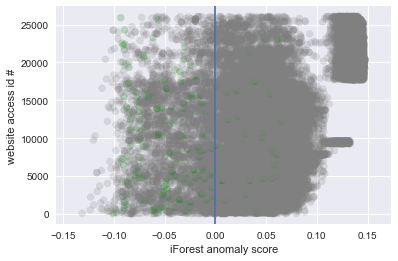

In [27]:
arr1 = X['anomaly_score']
arr2 = X.index
labl = X['GoodBot']
color= ['gray' if l == 0 else 'green' for l in labl]
plt.scatter(arr1, arr2, color=color, alpha=0.2)
plt.axvline(x=0)
plt.xlabel('iForest anomaly score')
plt.ylabel('website access id #')
plt.show()

## One-class SVM

As per scikit learn documentation, the One-class SVM is not an outlier-detection method but a novelty-detection method, its training set should not have outliers as it may fit them. (Otherwise known as a semi-supervised method which uses only normal examples during training  to build a model of normality). However, One-class SVM gives useful results in outlier detection in high-dimension dataset with no known distribution of the data.

In [28]:
drop_list = ['GoodBot', 'api/hour','frequent/hour']
X.drop(drop_list, axis = 1, inplace = True)

In [29]:
X_train, X_test = train_test_split(X, test_size = 0.12, random_state = 100)

In [30]:
SVM = svm.OneClassSVM(nu=0.2, kernel="rbf", gamma=0.00004)
%timeit SVM.fit(X_train)
pred_OCSVM = SVM.predict(X_test)

1 loop, best of 3: 3min 28s per loop


In [31]:
# there are many more outliers than inliers
itemfreq(pred_OCSVM)

array([[  -1, 3015],
       [   1,  119]], dtype=int64)

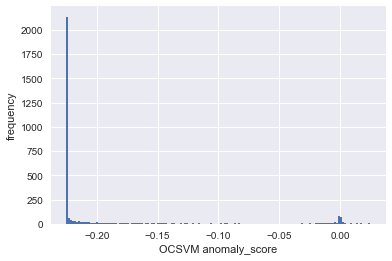

In [32]:
anomaly_score = SVM.decision_function(X_test)
plt.hist(anomaly_score, bins=150)
plt.xlabel('OCSVM anomaly_score')
plt.ylabel('frequency')
plt.show()

In [33]:
X["GoodBot"] = df['userAgentHttp'].str.contains("bot", case = False).astype(int) 
X['api/hour'] = df.groupby(['addressHttp','time'])['addressHttp'].transform('count')
X['frequent/hour'] = np.where(df.groupby(['addressHttp','time'])['addressHttp'].transform('count')>80, 1, 0)

In [34]:
X_test['pred_OCSVM'] = pred_SVM
X_test['anomaly_score'] = anomaly_score
X_test["GoodBot"] = X["GoodBot"]
X_test['api/hour'] = X['api/hour']
X_test['frequent/hour'] = X['frequent/hour']

In [35]:
# did OCSVM detect our known bots
tabs=pd.crosstab(X_test.pred_OCSVM, X_test.GoodBot, margins=True)
tabs

GoodBot,0,1,All
pred_OCSVM,,,
-1,2988,27,3015
1,119,0,119
All,3107,27,3134


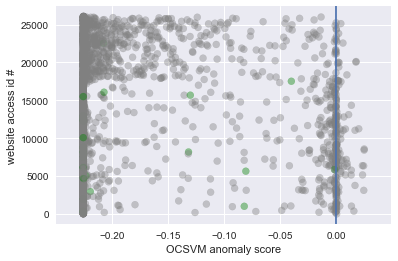

In [36]:
arr1 = X_test['anomaly_score']
arr2 = X_test.index
labl = X_test['GoodBot']
color= ['gray' if l == 0 else 'green' for l in labl]
plt.scatter(arr1, arr2, color=color, alpha=0.4)
plt.axvline(x=0)
plt.xlabel('OCSVM anomaly score')
plt.ylabel('website access id #')
plt.show()

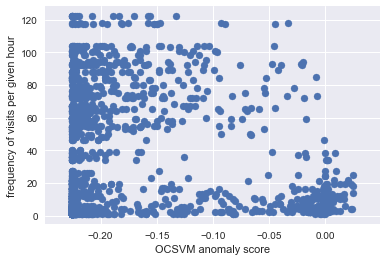

In [37]:
plt.scatter(anomaly_score,X_test['api/hour'])
plt.xlabel('OCSVM anomaly score')
plt.ylabel('frequency of visits per given hour')
plt.show()

## Local outlier factor

In [40]:
lof = LocalOutlierFactor(n_neighbors=35, leaf_size=30, contamination=0.15)

In [41]:
drop_list = ['GoodBot', 'api/hour','frequent/hour']
X.drop(drop_list, axis = 1, inplace = True)

In [42]:
X_train, X_test = train_test_split(X, test_size = 0.12, random_state = 100)

In [43]:
loft = lof.fit(X_train)
Y_pred_train = lof.fit_predict(X_train)
Y_pred_test = lof.fit_predict(X_test)
lofdf = lof._decision_function(X_test)

In [44]:
scores_pred = lof.negative_outlier_factor_
print(scores_pred)

[-1.03051365 -1.06038521 -1.01425754 ..., -1.00233129 -1.03365879
 -1.02447172]


In [45]:
X["GoodBot"] = df['userAgentHttp'].str.contains("bot", case = False).astype(int)
X['api/hour'] = df.groupby(['addressHttp','time'])['addressHttp'].transform('count')
X['frequent/hour'] = np.where(df.groupby(['addressHttp','time'])['addressHttp'].transform('count')>80, 1, 0)

In [46]:
X_test["LOFy"] = Y_pred_test
X_test['lofdf'] = lofdf
X_test["GoodBot"] = X["GoodBot"]
X_test['frequent/hour'] = X['frequent/hour']

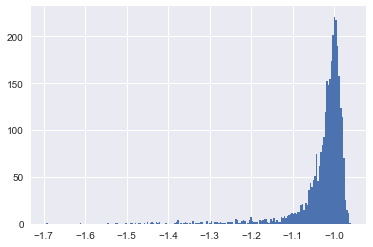

In [47]:
X_test.lofdf.hist(bins=200)
plt.show()

In [48]:
loftabs=pd.crosstab(X_test.LOFy, X_test.GoodBot, margins=True)  # if need to split by a 3rd category
loftabs

GoodBot,0,1,All
LOFy,,,
-1,466,4,470
1,2641,23,2664
All,3107,27,3134


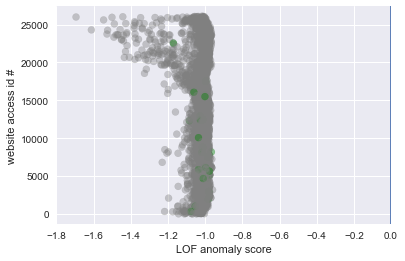

In [51]:
arr1 = X_test['lofdf']
arr2 = X_test['counter']
labl = X_test['GoodBot']
color= ['gray' if l == 0 else 'green' for l in labl]
plt.axvline(x=0)
plt.xlim (-1.8, 0)
plt.scatter(arr1, arr2, color=color, alpha=0.4)
plt.xlabel('LOF anomaly score')
plt.ylabel('website access id #')
plt.show()

## Elliptic envelope
Outlier detection from covariance estimation may break or not perform well in high-dimensional settings.

In [52]:
ee = EllipticEnvelope(contamination=0.15)

In [53]:
drop_list = ['GoodBot', 'api/hour','frequent/hour']
X.drop(drop_list, axis = 1, inplace = True)

In [54]:
eef = ee.fit(X)
X_ee = ee.predict(X)

C:\Users\sk1558\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


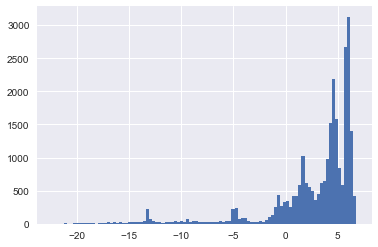

In [55]:
eescores = ee.decision_function(X)
X['ee_score'] = eescores
X.ee_score.hist(bins=100)
plt.show()

In [56]:
X["GoodBot"] = df['userAgentHttp'].str.contains("bot", case = False).astype(int)
X['api/hour'] = df.groupby(['addressHttp','time'])['addressHttp'].transform('count')
X['frequent/hour'] = np.where(df.groupby(['addressHttp','time'])['addressHttp'].transform('count')>15, 1, 0)

In [57]:
X['ee'] = X_ee
my = pd.crosstab(X.ee, X.GoodBot, margins=True)
my

GoodBot,0,1,All
ee,,,
-1,3767,150,3917
1,22160,33,22193
All,25927,183,26110


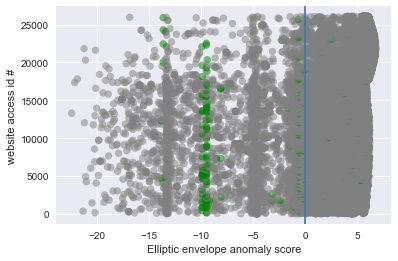

In [59]:
arr1 = X['ee_score']
arr2 = X['counter']
labl = X['GoodBot']
color= ['gray' if l == 0 else 'green' for l in labl]
plt.axvline(x=0)
plt.scatter(arr1, arr2, color=color, alpha=0.5)
plt.xlabel('Elliptic envelope anomaly score')
plt.ylabel('website access id #')
plt.show()